# Stock Price Movement Prediction Using The Deutsche Börse Public Dataset & Machine Learning - Notebook 1 (Obtain, Clean & Understand Data)

We begin by getting one day's worth of data to understand its structure and determine how to prepare it for analysis.

From there, we look at the behaviour of the data points within. Insights gathered here will inform later stages of work.

## 1. Obtaining Data

We start by finding what files are available for a particular date by running an `aws s3 ls` on the PDS AWS S3 bucket.
Note the `--no-sign-request` parameter. This means you don't need to have an AWS key or account for this to work.

In [1]:
date = '2018-03-26'

In [2]:
! aws s3 ls s3://deutsche-boerse-xetra-pds/{date}/ --no-sign-request 

2018-04-04 18:07:23        136 2018-03-26_BINS_XETR00.csv
2018-04-04 18:07:23        136 2018-03-26_BINS_XETR01.csv
2018-04-04 18:07:23        136 2018-03-26_BINS_XETR02.csv
2018-04-04 18:07:23        136 2018-03-26_BINS_XETR03.csv
2018-04-04 18:07:23        251 2018-03-26_BINS_XETR04.csv
2018-04-04 18:07:24        136 2018-03-26_BINS_XETR05.csv
2018-04-04 18:07:23        136 2018-03-26_BINS_XETR06.csv
2018-04-04 18:07:24     999016 2018-03-26_BINS_XETR07.csv
2018-04-04 18:07:24     882055 2018-03-26_BINS_XETR08.csv
2018-04-04 18:07:24     861920 2018-03-26_BINS_XETR09.csv
2018-04-04 18:07:24     816397 2018-03-26_BINS_XETR10.csv
2018-04-04 18:07:24     793111 2018-03-26_BINS_XETR11.csv
2018-04-04 18:07:24     848602 2018-03-26_BINS_XETR12.csv
2018-04-04 18:07:24    1094364 2018-03-26_BINS_XETR13.csv
2018-04-04 18:07:24    1260469 2018-03-26_BINS_XETR14.csv
2018-04-04 18:07:24     870234 2018-03-26_BINS_XETR15.csv
2018-04-04 18:07:26        136 2018-03-26_BINS_XETR16.csv
2018-04-04 18:

Download the files into a local folder. We use `aws s3 sync` command to syncronize a DBG public dataset folder
with a local folder. This command is *idempotent* so you can run it multiple times.

In [3]:
! mkdir -p /data/deutsche-boerse-xetra-pds/{date}
! aws s3 sync s3://deutsche-boerse-xetra-pds/{date} /data/deutsche-boerse-xetra-pds/{date} --no-sign-request
! ls /data/deutsche-boerse-xetra-pds/{date}

2018-03-26_BINS_XETR00.csv  2018-03-26_BINS_XETR13.csv
2018-03-26_BINS_XETR01.csv  2018-03-26_BINS_XETR14.csv
2018-03-26_BINS_XETR02.csv  2018-03-26_BINS_XETR15.csv
2018-03-26_BINS_XETR03.csv  2018-03-26_BINS_XETR16.csv
2018-03-26_BINS_XETR04.csv  2018-03-26_BINS_XETR17.csv
2018-03-26_BINS_XETR05.csv  2018-03-26_BINS_XETR18.csv
2018-03-26_BINS_XETR06.csv  2018-03-26_BINS_XETR19.csv
2018-03-26_BINS_XETR07.csv  2018-03-26_BINS_XETR20.csv
2018-03-26_BINS_XETR08.csv  2018-03-26_BINS_XETR21.csv
2018-03-26_BINS_XETR09.csv  2018-03-26_BINS_XETR22.csv
2018-03-26_BINS_XETR10.csv  2018-03-26_BINS_XETR23.csv
2018-03-26_BINS_XETR11.csv  success
2018-03-26_BINS_XETR12.csv


## 2. Data Preprocessing 

We need to load the data into a pandas dataframe and format it.

In [4]:
# Introduce imports which we will use next
import pandas as pd
import numpy as np
import glob, os
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

In [5]:
# Load the files from a date directory
def load_csv_dir(data_dir):
    return pd.concat(map(pd.read_csv, glob.glob(os.path.join(data_dir, '*.csv'))))

data_dir = '/data/deutsche-boerse-xetra-pds/%s/' % date
print("Loading from {}".format(data_dir))
unprococessed_df = load_csv_dir(data_dir)

Loading from /data/deutsche-boerse-xetra-pds/2018-03-26/


In [6]:
# Introduce a new column called CalcDateTime that is a timestamp calculated from the date and time string columns
time_fmt = "%H:%M"

def convert_time(time):
    return datetime.strptime(time, time_fmt)

def convert_dt(date, time):
    return datetime.strptime(date + ' ' + time, '%Y-%m-%d %H:%M')

unprococessed_df["CalcTime"] = unprococessed_df.apply(lambda row: convert_time(row['Time']), axis=1)
unprococessed_df["CalcDateTime"] = unprococessed_df.apply(lambda row: convert_dt(row['Date'], row['Time']), axis=1)

In [7]:
# Only keep common stock securities for analysis
only_common_stock = unprococessed_df[unprococessed_df.SecurityType == 'Common stock']
print("Common stock: {}, Other: {}".format(only_common_stock.count()[0], unprococessed_df[unprococessed_df.SecurityType != 'Common stock'].count()[0]))

Common stock: 59550, Other: 11284


In [8]:
# Keep only data points with trades between the opening and closing hours
opening_hours = datetime.strptime("08:00", time_fmt)
closing_hours = datetime.strptime("20:00", time_fmt)

cleaned_common_stock = only_common_stock[(only_common_stock.TradedVolume > 0) & \
                  (only_common_stock.CalcTime >= opening_hours) & \
                  (only_common_stock.CalcTime <= closing_hours)]

Notice: they are indexed, unsorted by `Mnemonic` or `CalcDateTime`.

In [9]:
cleaned_common_stock.head()

,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,CalcTime,CalcDateTime
1,CH0038389992,BBZA,"BB BIOTECH NAM. SF 0,20",Common stock,EUR,2504244,2018-03-26,10:00,56.800,56.800,56.800,56.800,650,6,1900-01-01 10:00:00,2018-03-26 10:00:00
2,CH0108503795,M6YA,"MEYER BUR.TECH.NAM.SF-,05",Common stock,EUR,2504246,2018-03-26,10:00,1.172,1.172,1.172,1.172,1630,1,1900-01-01 10:00:00,2018-03-26 10:00:00
4,DE000A0DJ6J9,S92,SMA SOLAR TECHNOL.AG,Common stock,EUR,2504287,2018-03-26,10:00,55.400,55.400,55.400,55.400,108,1,1900-01-01 10:00:00,2018-03-26 10:00:00
5,DE000A0D6554,NDX1,NORDEX SE O.N.,Common stock,EUR,2504290,2018-03-26,10:00,8.214,8.300,8.214,8.298,19997,46,1900-01-01 10:00:00,2018-03-26 10:00:00
6,DE000A0H52F5,MVV1,MVV ENERGIE AG NA O.N.,Common stock,EUR,2504336,2018-03-26,10:00,24.600,24.600,24.600,24.600,27,1,1900-01-01 10:00:00,2018-03-26 10:00:00


## 3. Inspecting Time Series

Now that we have a well-formatted data frame of common stock, let's inspect examples.

We plot four key price features: `EndPrice`, `StartPrice`, `MinPrice`, `MaxPrice`.

In later work, we'll make use of these features to predict the EndPrice at the next minute.

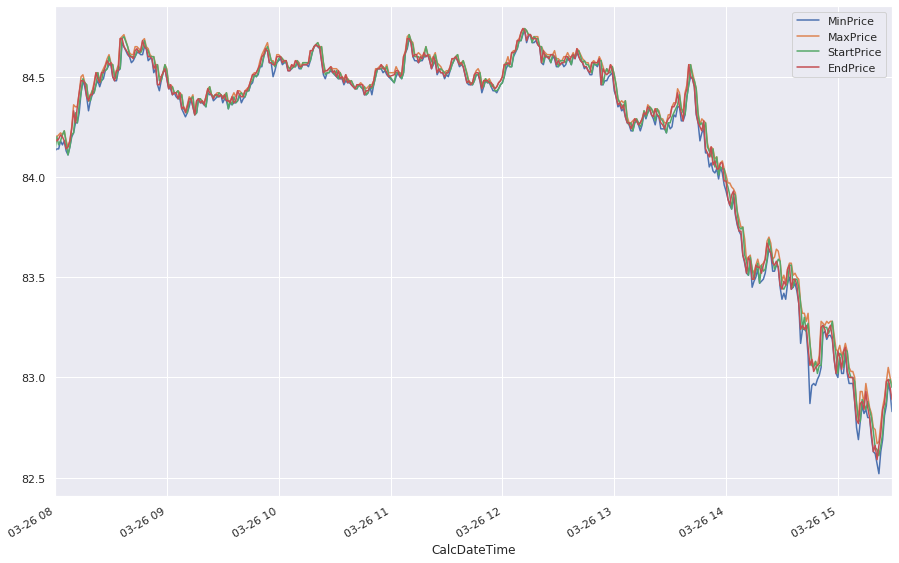

In [10]:
mpl.rcParams['figure.figsize'] = (15, 10) # use bigger graphs
def timeseries_plot(df, mnemonics, metrics):
    ax = None
    for mnemonic in mnemonics:
        for metric in metrics:
            selected = df[df.Mnemonic == mnemonic][['CalcDateTime', metric]].copy()
            selected.index = selected['CalcDateTime']
            selected = selected.sort_index()
            del selected['CalcDateTime']
            ax = selected.plot( ax = ax)
    
timeseries_plot(cleaned_common_stock, ['SAP'], ['MinPrice', 'MaxPrice', 'StartPrice', 'EndPrice']) 

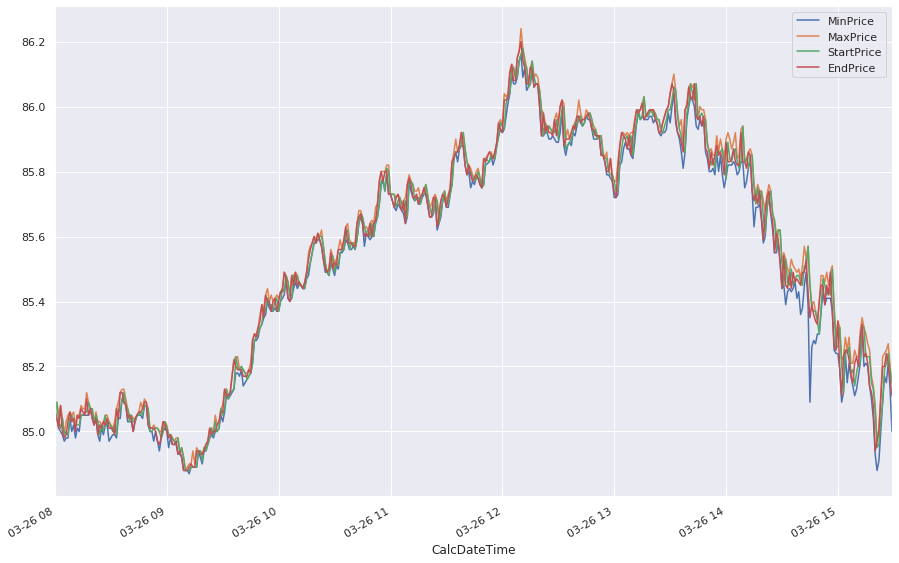

In [11]:
timeseries_plot(cleaned_common_stock, ['BMW'], ['MinPrice', 'MaxPrice', 'StartPrice', 'EndPrice']) 

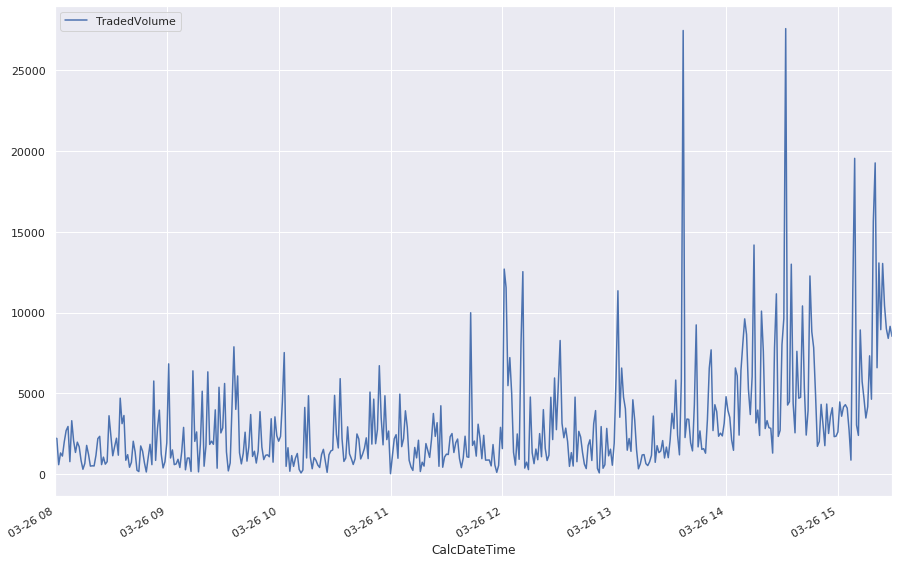

In [12]:
timeseries_plot(cleaned_common_stock, ['BMW'], ['TradedVolume'])

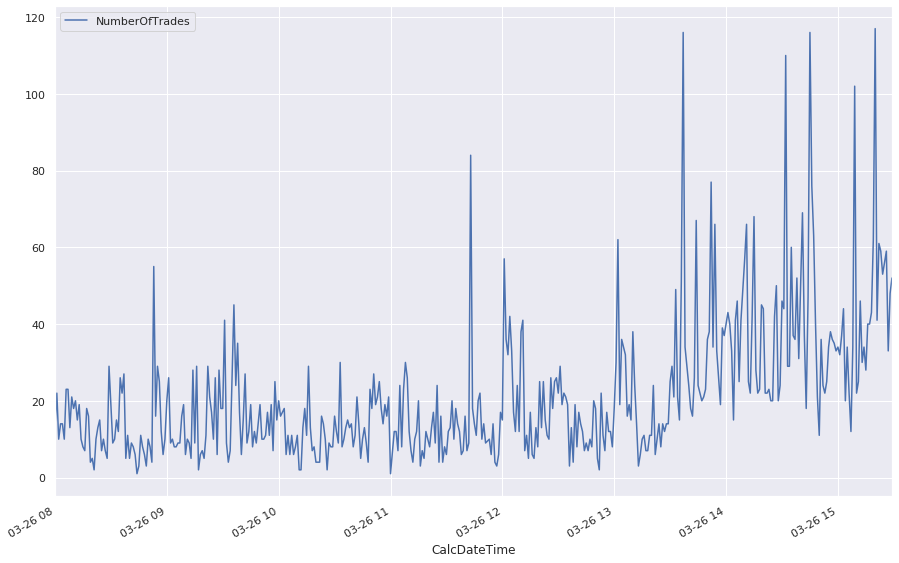

In [13]:
timeseries_plot(cleaned_common_stock, ['BMW'], ['NumberOfTrades'])

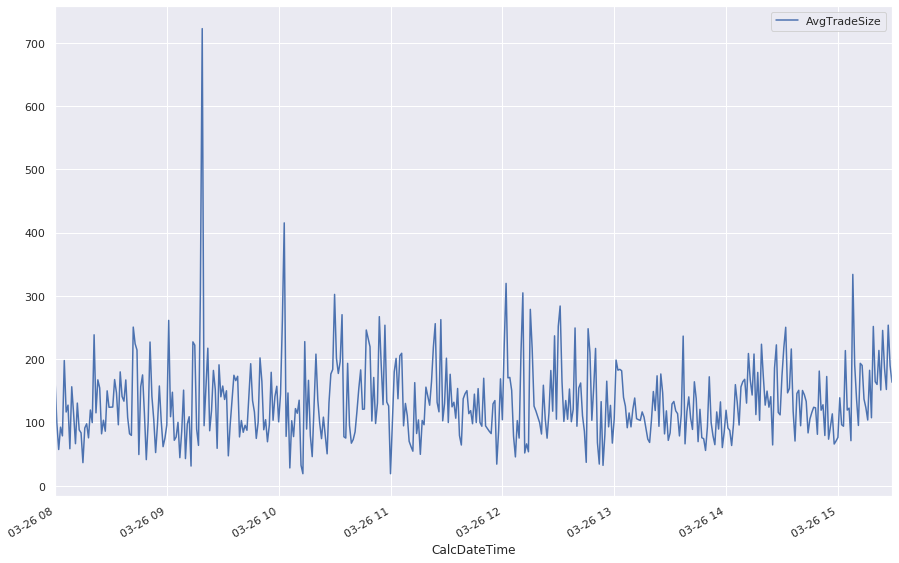

In [14]:
df = cleaned_common_stock
mnemonic = 'BMW'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
selected = selected.sort_index()
selected['AvgTradeSize'] = selected['TradedVolume'] / (0.1 + selected['NumberOfTrades'])
selected[['AvgTradeSize']].plot()

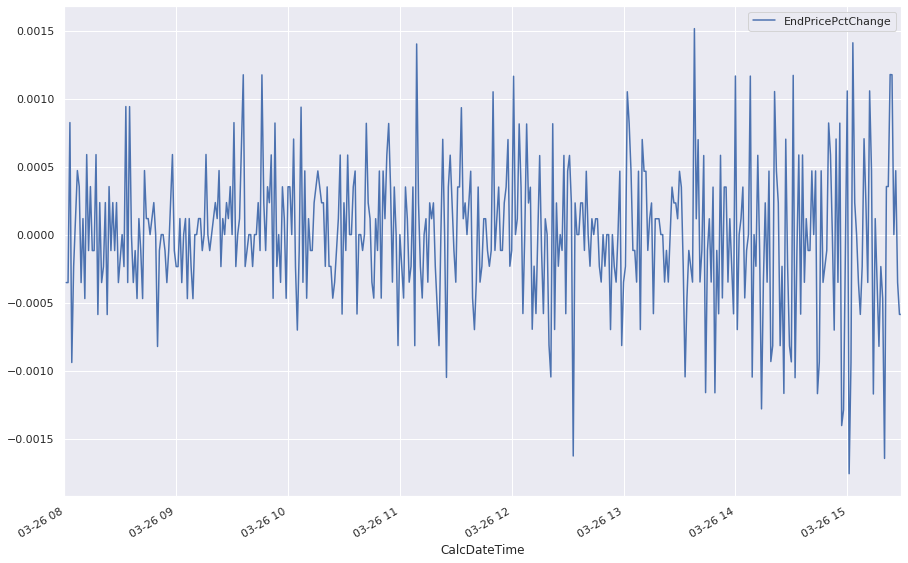

In [15]:
# Compute and plot pct change
df = cleaned_common_stock
mnemonic = 'BMW'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
selected = selected.sort_index()
selected['EndPricePctChange'] = selected['EndPrice'].pct_change()
selected[['EndPricePctChange']].plot()

## 4. Resampling the data into 15 minute intervals to observe trends

As we can see, minute-by-minute data confers high granularity and we see many fluctuations over time. However, it is also useful to resample and summarise the data into longer intervals, in this case 15 minutes. This has the effect of 'smoothing' the data and allows us to see trends that are obscured by the minute-by-minute fluctuations.

In [16]:
df = cleaned_common_stock
mnemonic = 'BMW'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
selected = selected.sort_index()
interval = '15Min'
resampled = pd.DataFrame({
    'EndPrice': selected['EndPrice'].resample(interval).last(),
    'StartPrice': selected['StartPrice'].resample(interval).first(),    
    'MinPrice': selected['MinPrice'].resample(interval).min(),  
    'MaxPrice': selected['MaxPrice'].resample(interval).max(),   
})

### Observation 1

We can observed from the graph below:

- When there is a downward trend, the `EndPrice` is closer to the `MinPrice`, than to the `MaxPrice`
- When there is an upward trend, the `EndPrice` is closer to `MaxPrice` than to the `MinPrice`

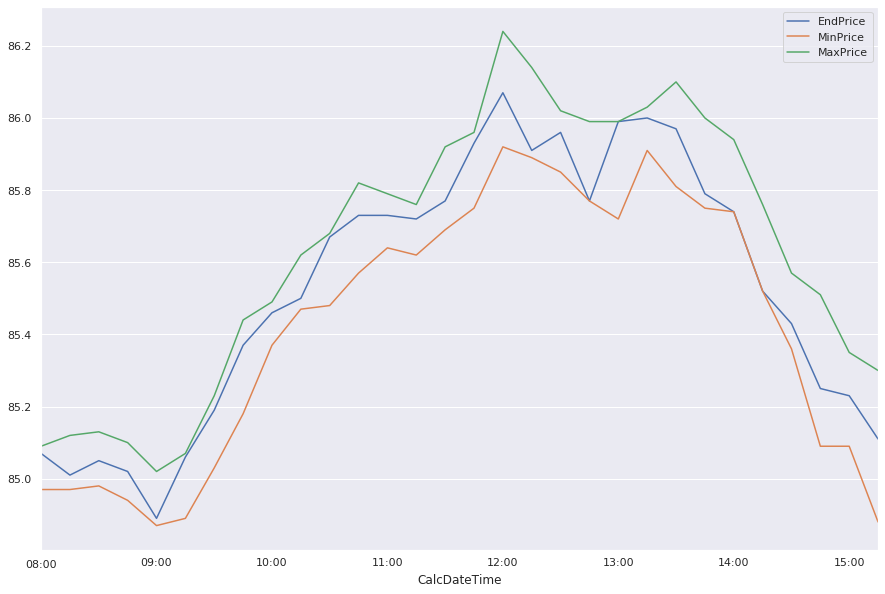

In [17]:
resampled[['EndPrice', 'MinPrice', 'MaxPrice']].plot()

### Observation 2
Similar (and correlated) behavior is true for the `StartPrice`:

- When there is a downward trend, the `StartPrice` is closer to the `MaxPrice`, than to the `MinPrice`
- When there is an upward trend, the `StartPrice` is closer to `MinPrice` than to the `MaxPrice`

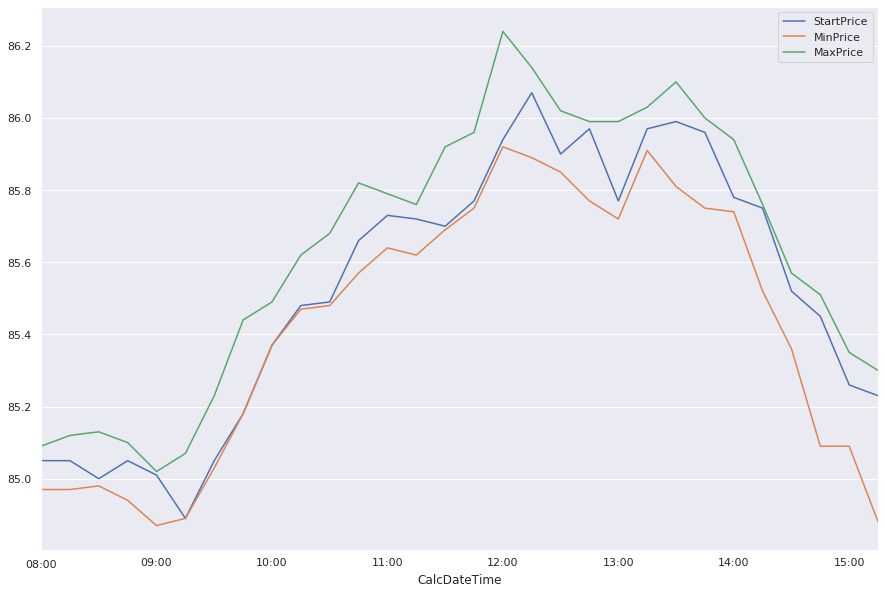

In [18]:
resampled[['StartPrice', 'MinPrice', 'MaxPrice']].plot()

### Observation 3

Another observation that can be made is that:
- when the trend is upwards, `EndPrice` is above `StartPrice`
- when the trend is downwars, `EndPrice` is below `StartPrice`
    
Therefore: if the lines of `EndPrice` and `StartPrice` cross, one could expect trend reversal.
(Of course one needs to account for the variance, and false positives)

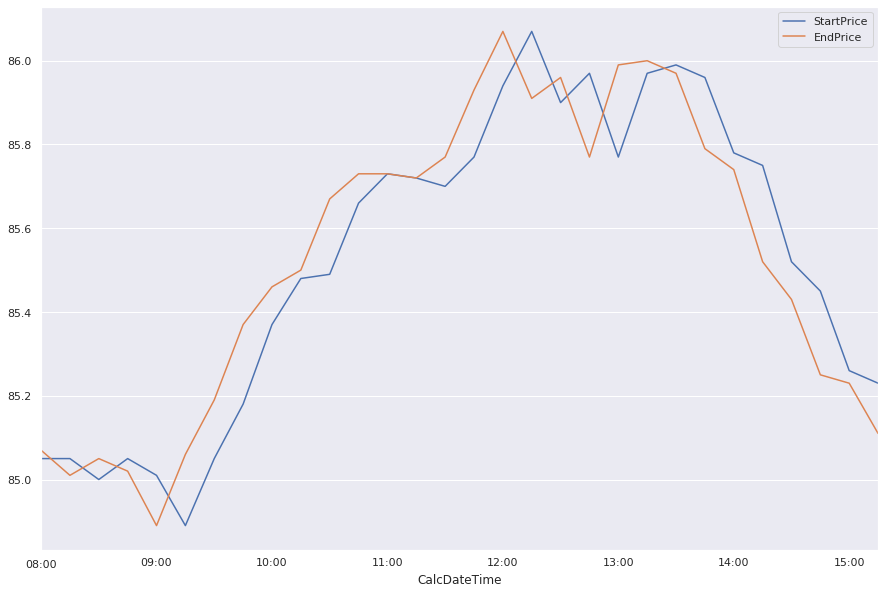

In [19]:
resampled[['StartPrice', 'EndPrice']].plot()

### Rate of return or percent change

Often times, when people model the stock market behavior, they are interested in the rates of return, or
how much do the price changes compared to the previous price.

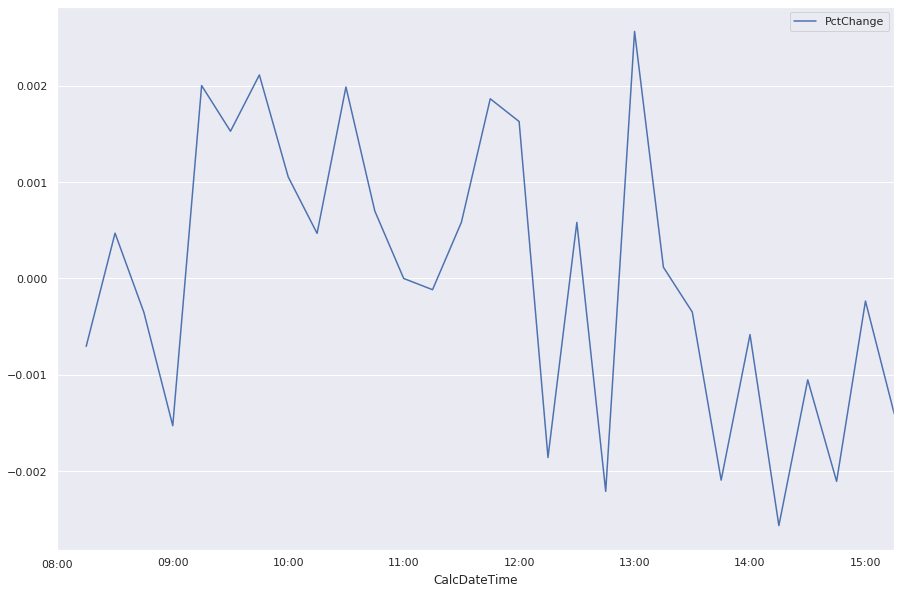

In [20]:
resampled['PctChange'] = resampled['EndPrice'].pct_change()
resampled[['PctChange']].plot()

### Correlation with Rate of Return

As a simple valiation of our observation from above regarding the relationship between prices and movements,
we can compute the correlation between an indicator and rate of return.
The indicator needs to be computed from the previous period.
This is what we did below. The interesting relationship is the correlation between `PctChange` and `Indicator[t - 1]`

In [21]:
def line_distance(df, a, b):
    return np.absolute(df[a] - df[b]) + np.absolute(df[a].shift(1) - df[b].shift(1))

distance_to_max_line = line_distance(resampled, 'MaxPrice', 'EndPrice')
distance_to_min_line = line_distance(resampled, 'MinPrice', 'EndPrice')

resampled['Indicator'] = (distance_to_min_line - distance_to_max_line)/100.0 # divide by 100 because the prices are around 100,
resampled['Indicator[t - 1]'] = resampled['Indicator'].shift(1)
resampled['PctChange[t - 1]'] = resampled['PctChange'].shift(1)

resampled[['PctChange',  'PctChange[t - 1]', 'Indicator', 'Indicator[t - 1]']].corr()[['PctChange']]

,PctChange
PctChange,1.000000
PctChange[t - 1],0.180227
Indicator,0.657189
Indicator[t - 1],0.327822


### Validation

We are not going to validate this finding further in this notebook, because our goal here was to build some intuition about the stock market.
Readers are encouraged to validate this finding using more data (more stocks and more days), as well as to explore:
- effect of interval resampling
- effect of correlation with next minute, next 15 minutes
- combine the three observations from above into a single indicator

### Histogram of indicator within a timeframe

We select the data between `10:00` and `11:00` and display the distribution of the indicators. This is a
period when there is an upward trend

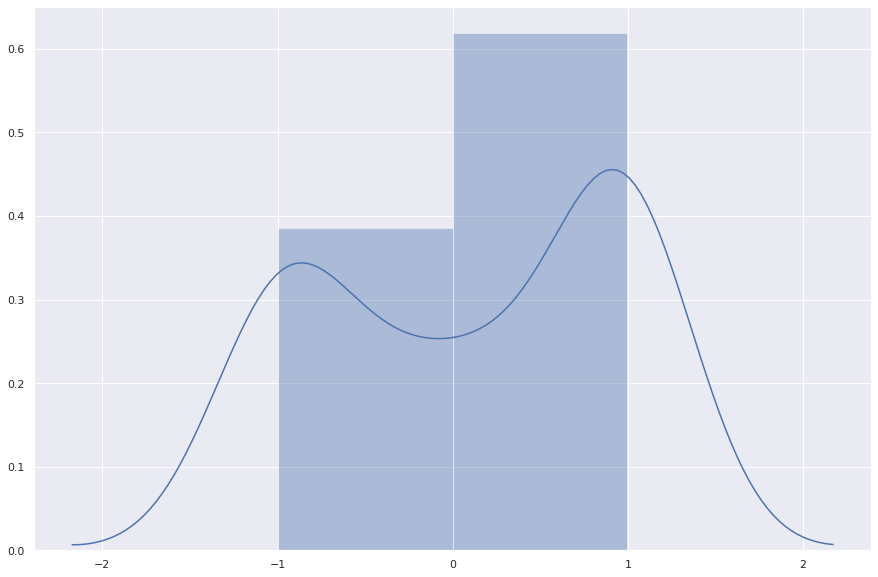

In [22]:
mnemonic = 'BMW'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
selected = selected.sort_index()
f = (selected.CalcDateTime >= datetime.strptime(date + ' 10:00', '%Y-%m-%d %H:%M')) & \
    (selected.CalcDateTime <= datetime.strptime(date + ' 10:59', '%Y-%m-%d %H:%M'))

selected = selected[f]

# add a small eps to avoid division by zero
eps = 0.01*((selected['MaxPrice'] - selected['MinPrice']).mean())
ind = -((selected['MaxPrice'] + selected['MinPrice']) - 2.0*selected['EndPrice'])/(eps + selected['MaxPrice'] - selected['MinPrice'])
# or this
#ind = np.sign((selected['MaxPrice'] + selected['MinPrice']) - 2.0*selected['EndPrice'])
selected['ind'] = ind

sns.distplot(ind)

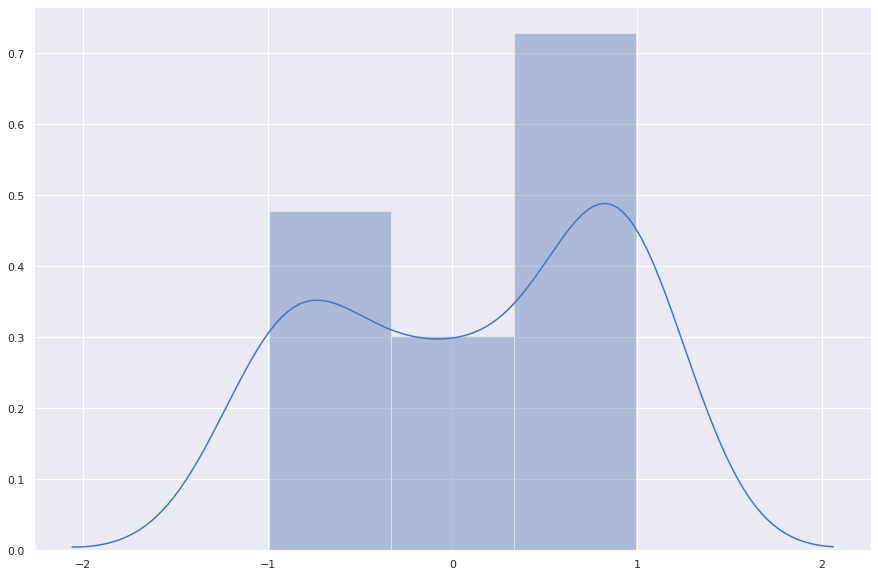

In [23]:
ind = np.sign(selected['EndPrice'] - selected['StartPrice']) 
selected['ind'] = ind

# or this
ind = selected['EndPrice'] - selected['StartPrice']
ind = ind / (eps + selected['MaxPrice'] - selected['MinPrice'])
selected['ind'] = ind

sns.distplot(ind)

Notice that we compute the directions over 1min, 2min, etc. intervals, but because the trend is
strong, they come with the same directrion, although larger intervals are less noisy

In [24]:
intervals = []
directions = []
confidences = []
for interval in ['1min', '2min', '5min', '10min', '15min']:
    e = selected['EndPrice'].resample(interval).last()
    s =  selected['StartPrice'].resample(interval).first()
    ind = np.sign(e - s) 
    p, n =  np.where(ind == 1.0, 1.0, 0.0).sum(), np.where(ind == -1.0, 1.0, 0.0).sum()
    agreement = max(p, n)/ind.shape[0]
    intervals.append(interval)
    directions.append(ind.mean())
    confidences.append(agreement)
    
pd.DataFrame({
    'interval': intervals,
    'direction': directions,
    'confidences': confidences
})[['interval', 'direction', 'confidences']]

,interval,direction,confidences
0,1min,0.133333,0.500000
1,2min,0.233333,0.600000
2,5min,0.166667,0.583333
3,10min,0.666667,0.833333
4,15min,1.000000,1.000000


From 12:00 to 14:00, there is no clear signal for up or down

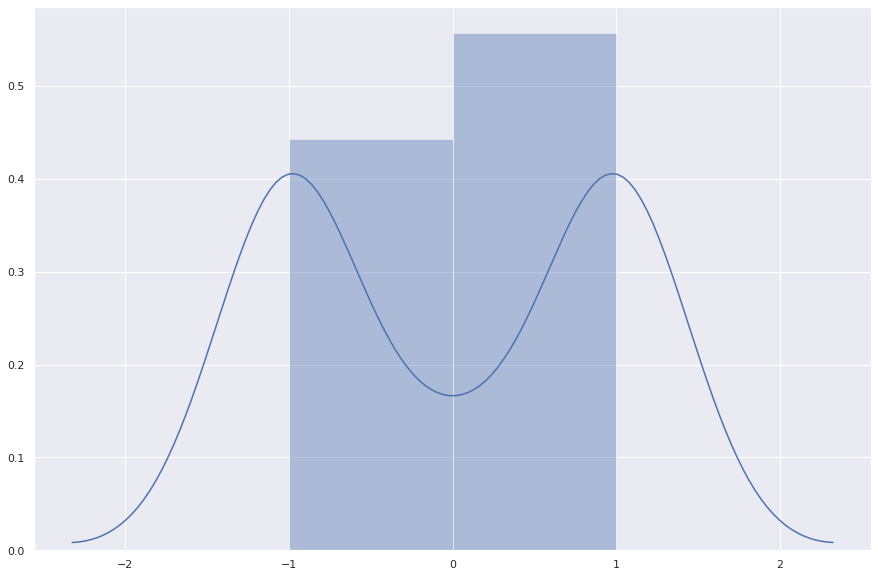

In [25]:
mnemonic = 'BMW'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
selected = selected.sort_index()
f = (selected.CalcDateTime >= datetime.strptime(date + ' 13:00', '%Y-%m-%d %H:%M')) & \
    (selected.CalcDateTime <= datetime.strptime(date + ' 14:00', '%Y-%m-%d %H:%M'))

selected = selected[f]

ind = np.sign(selected['EndPrice'] - selected['StartPrice']) 
selected['ind'] = ind


sns.distplot(ind)

For this time frame, different intervals come up with different direction because there is no clear trend.

In [26]:
intervals = []
directions = []
confidences = []
for interval in ['1min', '2min', '5min', '10min', '15min']:
    e = selected['EndPrice'].resample(interval).last()
    s =  selected['StartPrice'].resample(interval).first()
    ind = np.sign(e - s) 
    p, n =  np.where(ind == 1.0, 1.0, 0.0).sum(), np.where(ind == -1.0, 1.0, 0.0).sum()
    agreement = max(p, n)/ind.shape[0]
    intervals.append(interval)
    directions.append(ind.mean())
    confidences.append(agreement)
    
pd.DataFrame({
    'interval': intervals,
    'direction': directions,
    'confidences': confidences
})[['interval', 'direction', 'confidences']]

,interval,direction,confidences
0,1min,0.000000,0.442623
1,2min,0.000000,0.451613
2,5min,-0.076923,0.538462
3,10min,0.428571,0.714286
4,15min,0.200000,0.600000


If we shift the interval by 30 minutes, from 13:30 to 14:30, we get a clear agreement between the intervals that the direction is down

In [27]:
mnemonic = 'BMW'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
selected = selected.sort_index()
f = (selected.CalcDateTime >= datetime.strptime(date + ' 13:30', '%Y-%m-%d %H:%M')) & \
    (selected.CalcDateTime <= datetime.strptime(date + ' 14:30', '%Y-%m-%d %H:%M'))

selected = selected[f]

ind = np.sign(selected['EndPrice'] - selected['StartPrice']) 
selected['ind'] = ind

intervals = []
directions = []
confidences = []
for interval in ['1min', '2min', '5min', '10min', '15min']:
    e = selected['EndPrice'].resample(interval).last()
    s =  selected['StartPrice'].resample(interval).first()
    ind = np.sign(e - s) 
    p, n =  np.where(ind == 1.0, 1.0, 0.0).sum(), np.where(ind == -1.0, 1.0, 0.0).sum()
    agreement = max(p, n)/ind.shape[0]
    intervals.append(interval)
    directions.append(ind.mean())
    confidences.append(agreement)
    
pd.DataFrame({
    'interval': intervals,
    'direction': directions,
    'confidences': confidences
})[['interval', 'direction', 'confidences']]

,interval,direction,confidences
0,1min,-0.196721,0.557377
1,2min,-0.258065,0.548387
2,5min,-0.538462,0.769231
3,10min,-0.428571,0.714286
4,15min,-1.000000,1.000000


### Crossover

The cross over points are defined as the points where the `StartPrice` goes above or below the `EndPrice`.
Such points indicate a trend reversal.
In the example below, the algorithm to compute the cross over points was manually tuned on this specific
dataset.

The peaks that point down indicate that the trend is downwards, while the peaks that point up, indicate
that the trend is upwards

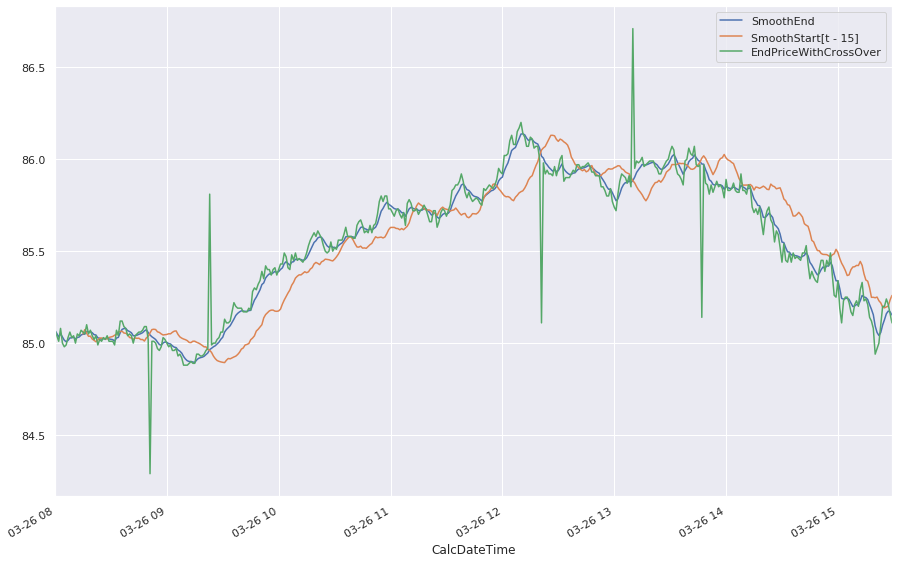

In [28]:
def cross_over(df, a, b, lam=0.0):
    previous_a = df[a].shift(1)
    previous_b = df[b].shift(1)
    
    da = np.absolute(previous_a - df[a]) > lam*previous_a
    db = np.absolute(previous_b - df[b]) > lam*previous_b
    
    f1 = (df[a] < df[b]) & (previous_a > previous_b)  & da & db
    f2 = (df[a] > df[b]) & (previous_a < previous_b) & da & db

    mag = 1.0 # 10.0*(np.absolute(previous_a - df[a]) + np.absolute(previous_b - df[b]))
    crossing = np.where(f1, -mag, np.where(f2, mag, 0.0))
    return crossing

mnemonic = 'BMW' # try as well with 'SAP' and 'SIE'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
selected = selected.sort_index()
d = 15
start = selected['StartPrice'].shift(d).ewm(com=2.5).mean()
end = selected['EndPrice'].ewm(com=2.5).mean()
selected['SmoothEnd'] = end
selected['SmoothStart[t - 15]'] = start

# Warning: we look 10 minutes into the future, so to say via shift(-10)
# TODO: it might be better to compute the sum of signs on on side of the point and on the other one

ind = np.sign(selected['StartPrice'].shift(5) - selected['EndPrice'].shift(-10)).rolling(10, min_periods =5).mean()

magnitude = np.where(np.absolute(ind) > 0.52, np.absolute(ind), 0.0)

selected['CrossOver'] = magnitude*cross_over(selected, 'SmoothEnd', 'SmoothStart[t - 15]', 0.00005)

# suppress points which don't alternate signs
v = selected['CrossOver'].values
l = list(filter(lambda ix: ix[1] != 0.0, enumerate(v)))
for j in range(1, len(l)):
    if l[j][1] * l[j - 1][1] > 0:
        v[l[j][0]] = 0.0 #updates CrossOver inplace

selected['EndPriceWithCrossOver'] = selected['EndPrice'] + 0.8*selected['CrossOver']
selected[['SmoothEnd', 'SmoothStart[t - 15]', 'EndPriceWithCrossOver']].plot()    

## Next steps: dense neural nets and convolutional neural nets

Observe that our indicator metric is a linear combination of features, which can be followed by a non-linear thresholding operation. Moreover, we have actually 3 indicators. The distances we computed were computed between lines, but they could be computed between data points.

This is an ideal situation for a two-layer neural network with one hidden dense layer.
In the notebooks to follow we will show that such indicators (features) can be synthesized automatically.

Another observation is that we can resample data into 1 minute, 2 minute, 15 minutes, etc.
For each type of resampling one can compute the same types of features. Indeed, such operations are common for convolutional neural networks 

In [29]:
! echo "Last run on $(date)"

Last run on Wed Jan 22 18:43:43 UTC 2020
